# Function Call Overhead
:label:`ch_call_overhead`

We are starting to benchmark various schedules since this chapter. Before diving into various execution time numbers, we need to be aware of the overhead of issuing a function call in Python. It's well known that Python is not the fastest language on earth. Prototyping with Python is fast, but we also need to pay the cost that Python does smart things for us under the hook. In this section, we will investigate the overhead to call a function in Python, and demonstrate its impact to our later benchmarking results. 

## Execution Time Measurement

In Python, we often use the `timeit` module to benchmark a workload, especially when its execution time is way less than 1 second. Note that Jupyter has a magic build-in function `%timeit` that makes the usage simpler, but a function using it cannot be saved for future usage, so we will use `timeit` directly.


In [ ]:
import timeit
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

The following codes return the execution time of creating a `[4, 4]` zero matrix by 10 times.


In [ ]:
timer = timeit.Timer(setup='import numpy as np',
                     stmt='np.zeros((4, 4))')
timer.timeit(10)

We can see that the above workload can be done in tens of microsecond, we may need to increase the number of repeats to obtain relatively accurate execution time. 
The following function will determine the number of repeats needed to run a workload for at least 1 second, and then return the average execution time.


In [ ]:
# Save to the d2ltvm package.
def bench_workload(workload):
    """Benchmark a workload
    
    workload: a method that accept a num_repeat argument 
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

print('time for np.zeros((4, 4)):', bench_workload(timer.timeit))

We can see that the newly measured execution time of `np.zeros((4, 4))` is much smaller than the one we first measured, as the former one includes the warmup time.

## The Non-Negligible Overhead

Now we benchmark the `copyto` method, which copies the contents of an ndarray to another one, on various size ndarrays.


In [ ]:
def np_setup(n):
    return 'import numpy as np\n' \
           'x = np.random.normal(size=%d).astype("float32")\n' \
           'y = np.empty_like(x)\n'% n
        
def np_copy(n):
    return timeit.Timer(setup=np_setup(n),
                        stmt='np.copyto(y, x)')
    
sizes = 2**np.arange(5, 20, 4).astype('int')
exe_times = [bench_workload(np_copy(n).timeit) for n in sizes]

Plot the throughput versus vector length.


/tmp/ipykernel_92783/356713169.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


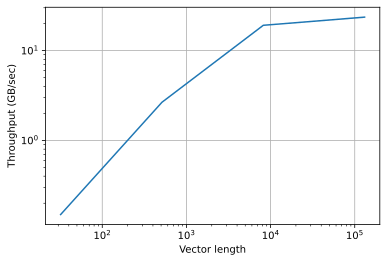

In [5]:
display.set_matplotlib_formats('svg')
# one float32 takes 4 bytes
plt.loglog(sizes, sizes*4/exe_times/1e9)
plt.xlabel('Vector length')
plt.ylabel('Throughput (GB/sec)')
plt.grid()

We can see that the throughput first increases and then plateaus. The plateau reflects the saturation of the memory bandwidth. However, the behavior of small vectors is not as expected since when the vector length is small, all data should be in the cache which should result in much higher throughput. To examine the reason, let's simply draw the execution time versus vector length.


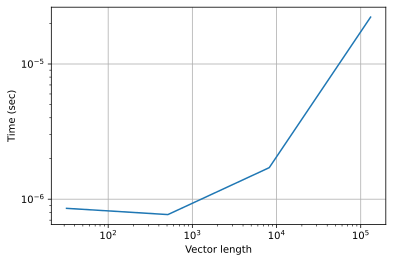

In [6]:
plt.loglog(sizes, exe_times)
plt.xlabel('Vector length')
plt.ylabel('Time (sec)')
plt.grid()

We can see that when the vector length is smaller than $10^3$, the execution time barely decrease when the vector length shortens. This is because when the vector length is short, the real `copyto` execution time is too small, and the total execution time is dominated by the function call overhead. The overhead includes any argument preprocessing in the Python function, evoking the foreign function interface, and other [Python backend overhead](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/). Therefore, benchmarking too small workloads is not quite meaningful. 

## Overhead of NumPy, TVM and MXNet

Throughout the book, we will benchmark various operators in Numpy, TVM and MXNet. Let's examine their function call overheads. We could roughly estimate it by executing some small workloads where the actual execution time is negligible compared to the overhead. Let's first check NumPy.


In [7]:
sizes = 2**np.arange(1, 8).astype('int')
exe_times = np.array([bench_workload(np_copy(n).timeit) for n in sizes])

print('NumPy call overhead: %.1f microsecond' % (exe_times.mean()*1e6))

NumPy call overhead: 0.8 microsecond


The overhead of TVM is higher but in the same order of magnitude.


In [8]:
def tvm_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import tvm\n'
                        'x, y = tvm.nd.array(x), tvm.nd.array(y)',
                        stmt='x.copyto(y)')

tvm_times = np.array([bench_workload(tvm_copy(n).timeit) for n in sizes])
print('TVM call overhead: %.1f microsecond'% (tvm_times.mean()*1e6,))

TVM call overhead: 0.7 microsecond


Compared to NumPy and TVM, MXNet has substantially higher overhead. The reason might due to MXNet uses `ctypes` while TVM is compiled with `cython`, and MXNet uses lazy evaluation that brings additional overhead.


In [9]:
def mx_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import mxnet as mx\n'
                        'x, y = mx.nd.array(x), mx.nd.array(y)\n'
                        'mx.nd.waitall()'% n,
                        stmt='x.copyto(y); y.wait_to_read()')

mx_times = np.array([bench_workload(mx_copy(n).timeit) for n in sizes])
print('MXNet call overhead: %.1f microsecond'% (mx_times.mean()*1e6,))

MXNet call overhead: 39.7 microsecond


## Summary

- Warming up a method by running it a few times beforehand is a good practice to measure its execution time.
- The function call overhead might takes several microsecond. Benchmarking too small functions in Python is meaningless.
